2025-06-10 13:10:23,001 | INFO    | ==========  STAGE 06: COMBINED WEIGHTED RISE PREDICTIONS ==========
2025-06-10 13:10:23,007 | INFO    | SWAN_YEAR=2008  RUN_DATE=20250609
2025-06-10 13:10:27,490 | INFO    | Snapshot year 2007 retained 974 rows
2025-06-10 13:10:27,494 | INFO    | Stage 6A: Calculating domain-weighted RISE predictions …
2025-06-10 13:10:27,547 | INFO    | ✓ NetIncome predictions added
2025-06-10 13:10:27,565 | INFO    | ✓ EarningBeforeInterestAndTax predictions added
2025-06-10 13:10:27,582 | INFO    | ✓ OperatingIncome predictions added
2025-06-10 13:10:27,610 | INFO    | ✓ EBITDA predictions added
2025-06-10 13:10:27,636 | INFO    | ✓ OperatingCashFlow predictions added
2025-06-10 13:10:27,657 | INFO    | ✓ FreeCashFlow predictions added
2025-06-10 13:10:27,687 | INFO    | ✓ Cash predictions added
2025-06-10 13:10:27,715 | INFO    | ✓ CashAndCashEquivalents predictions added
2025-06-10 13:10:27,743 | INFO    | ✓ TotalRevenue predictions added
2025-06-10 13:10:27,772

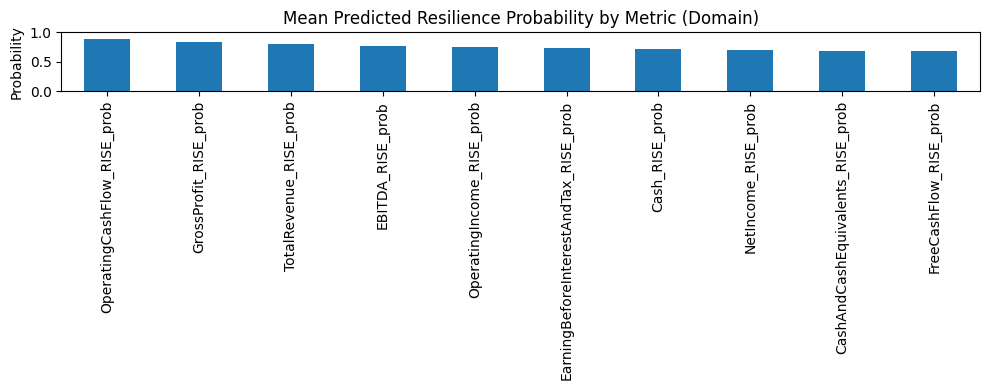

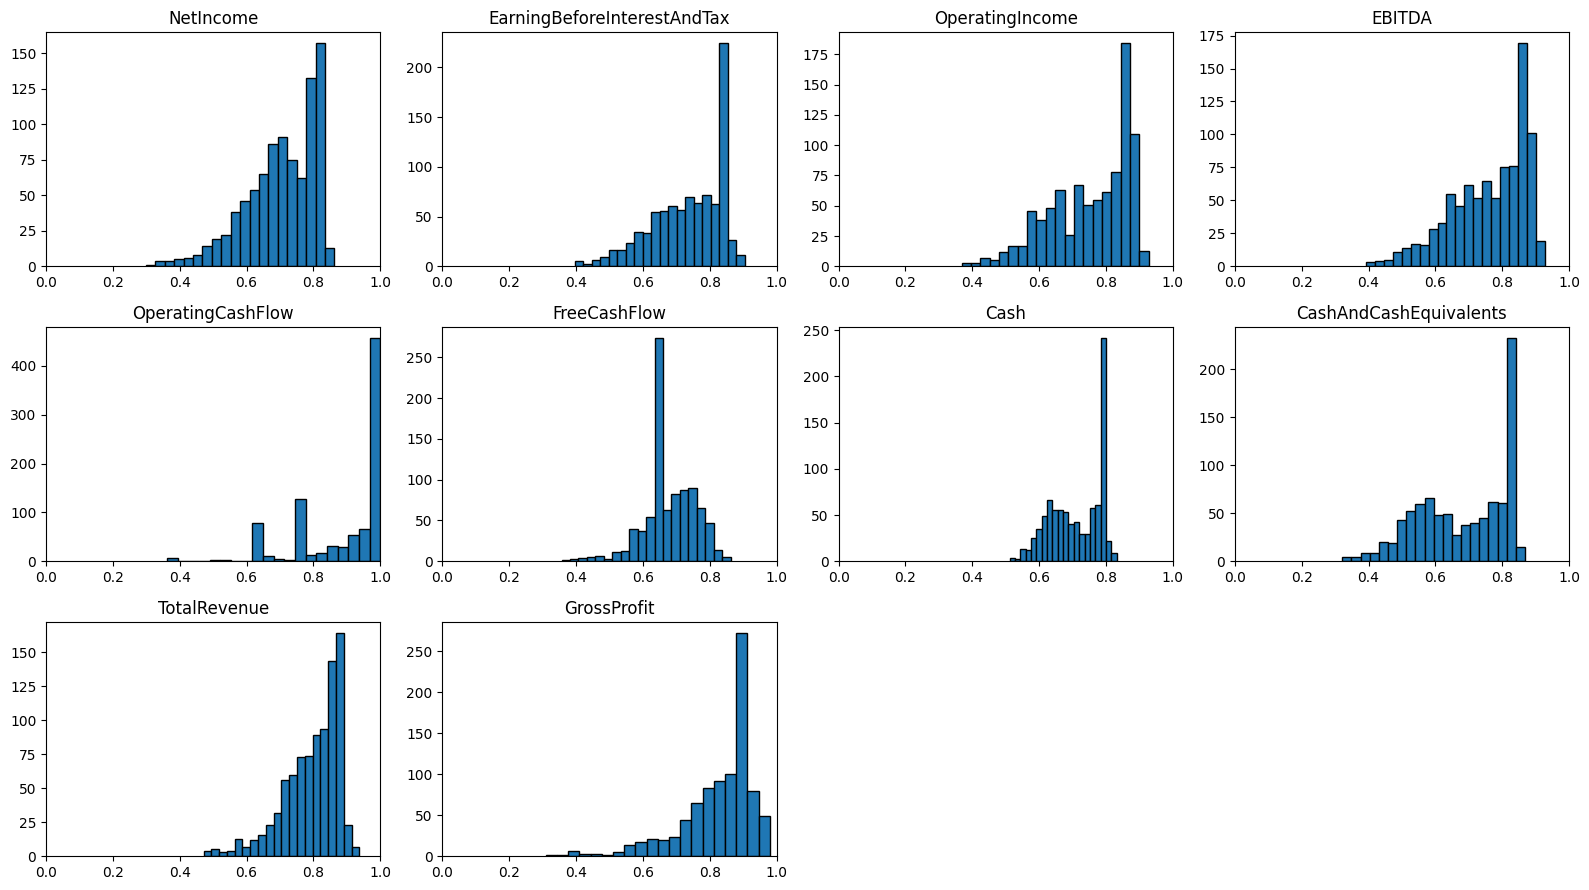


===== TOP 10 FIRMS BY MEAN RISE_PROB (Domain) =====
Symbol ReportDate  Mean_RISE_prob
   BOQ 2007-08-31        0.825385
 BOQPE 2007-08-31        0.825385
 BOQPF 2007-08-31        0.825385
 BOQPG 2007-08-31        0.825385
   ILU 2007-12-31        0.823961
   BPT 2007-06-30        0.822802
   VMT 2007-06-30        0.822238
   EGH 2007-06-30        0.821832
   OEC 2007-06-30        0.820456
  OECO 2007-06-30        0.820456

===== BOTTOM 10 FIRMS BY MEAN RISE_PROB (Domain) =====
Symbol ReportDate  Mean_RISE_prob
   HAW 2007-06-30        0.549115
   VML 2007-06-30        0.573085
   SRN 2007-06-30        0.576304
 SRNOD 2007-06-30        0.576304
   BIT 2007-06-30        0.591752
   NSX 2007-06-30        0.594453
   SPN 2007-06-30        0.595425
   NVA 2007-06-30        0.596328
   VPR 2007-12-31        0.598021
   CZN 2007-06-30        0.601446
2025-06-10 13:10:31,981 | INFO    | Stage 6B: Calculating stage-weighted RISE predictions …
2025-06-10 13:10:32,018 | INFO    | ✓ NetIncome pre

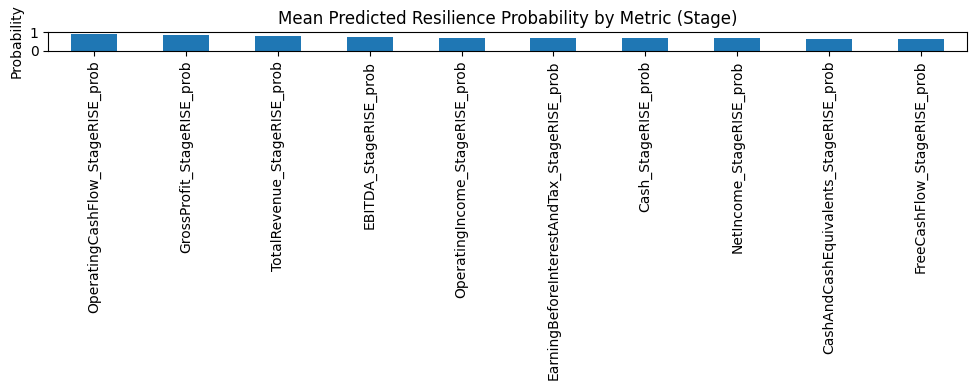

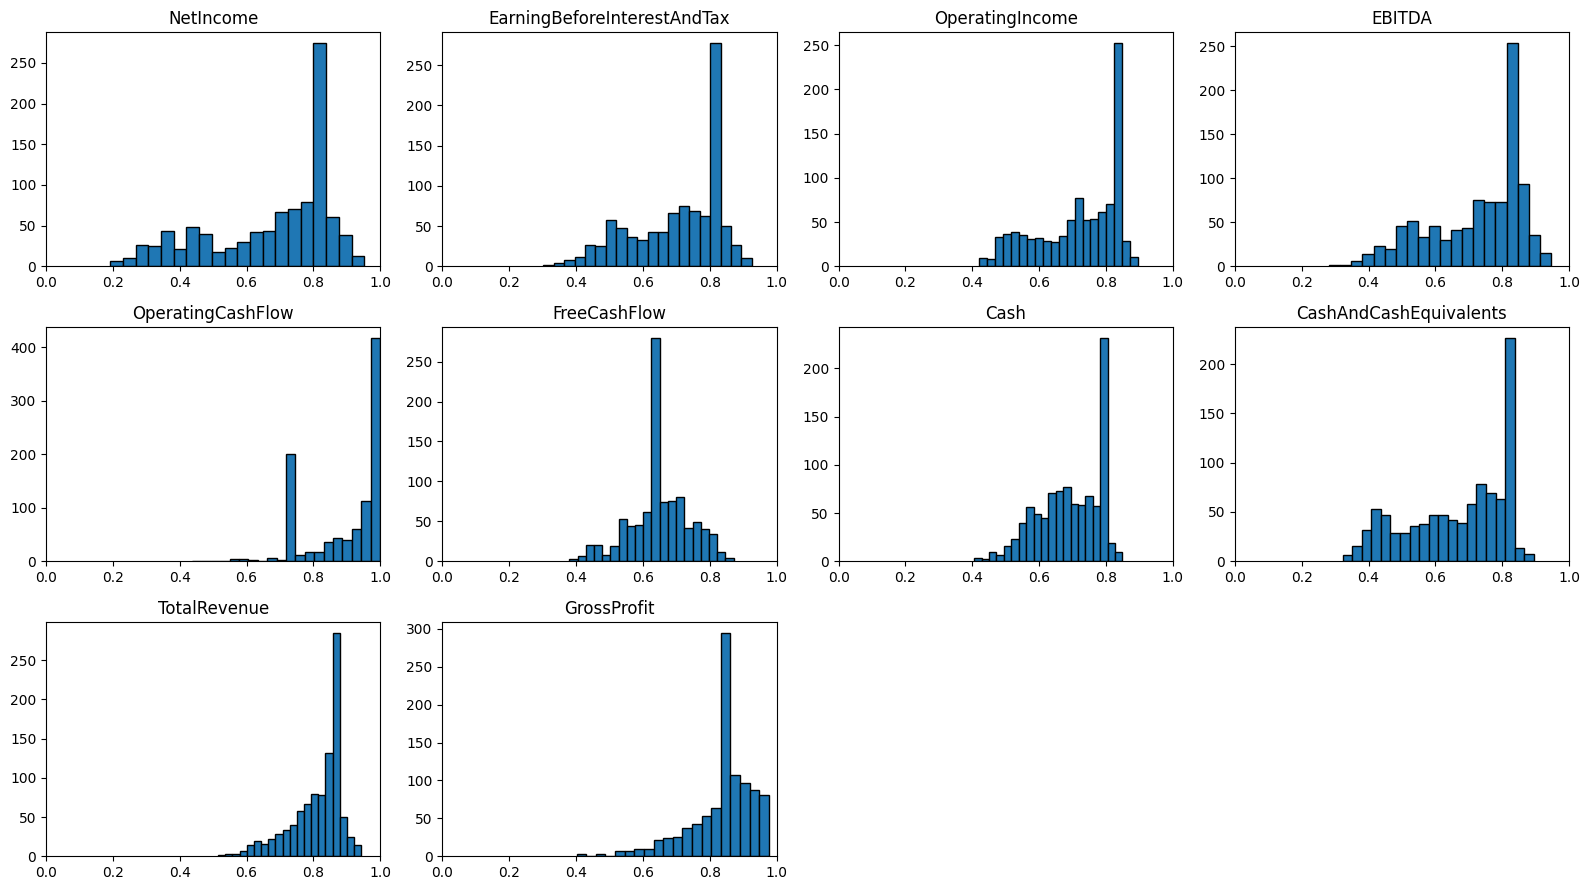


===== TOP 10 FIRMS BY MEAN STAGERISE_PROB =====
Symbol ReportDate  Mean_StageRISE_prob
   SSM 2007-06-30             0.849466
   LNW 2007-12-31             0.845560
   LAU 2007-06-30             0.844103
   TAH 2007-06-30             0.840801
   KSC 2007-06-30             0.839446
   GNC 2007-09-30             0.836242
   SKS 2007-06-30             0.835928
   QAN 2007-06-30             0.835270
   ECL 2007-06-30             0.835041
   OCL 2007-06-30             0.833536

===== BOTTOM 10 FIRMS BY MEAN STAGERISE_PROB =====
Symbol ReportDate  Mean_StageRISE_prob
   PTM 2007-06-30             0.554217
   IBC 2007-06-30             0.558372
   CAE 2007-06-30             0.560154
   CF1 2007-07-31             0.560154
   ETM 2007-06-30             0.566254
   GPR 2007-12-31             0.566254
   IPC 2007-06-30             0.566254
   PRU 2007-06-30             0.569804
   EME 2007-06-30             0.570099
   RWD 2007-12-31             0.579073
2025-06-10 13:10:35,739 | INFO    | 🎉 Sta

In [6]:
#!/usr/bin/env python
"""
STAGE 06 · COMBINED WEIGHTED RISE PREDICTIONS
────────────────────────────────────────────────────────────────────────────
Folder layout for one RUN_DATE:

<OUTPUT_DIR>/
 ├─ stage05a/                      ← yesterday’s “5a” (snapshot)
 │   └─ Stage5A_QuintilesAndScores.csv
 ├─ stage05b/                      ← yesterday’s “5b” (regressions)
 │   ├─ Stage5C_<Metric>_Coefficients.csv
 │   └─ Stage5D_<Metric>_StageCoefficients.csv
 └─ stage06/                       ← created here by this stage
     ├─ Stage6_RISE_Predictions.csv            (domain weighted)
     └─ Stage6B_Stage_RISE_Predictions.csv       (stage weighted)

Stage 6A – Domain-Weighted RISE:
   • Uses snapshot: stage05a/Stage5A_QuintilesAndScores.csv
   • Applies domain coefficients from stage05b/Stage5C_*_Coefficients.csv
Stage 6B – Stage-Weighted RISE:
   • Uses same snapshot
   • Applies stage coefficients from stage05b/Stage5D_*_StageCoefficients.csv

Diagnostics are produced (summary statistics, mean bar charts, histogram grid and top/bottom ranking displays)
to be visible in the notebook.
────────────────────────────────────────────────────────────────────────────
"""

from __future__ import annotations
import os, sys, logging, yaml, warnings
from pathlib import Path
import pandas as pd, numpy as np, matplotlib.pyplot as plt

# ───────────────────────── CONFIGURATION & LOGGER ─────────────────────────
if os.getenv("PIPELINE_CFG"):
    CFG_FILE = Path(os.getenv("PIPELINE_CFG")).expanduser()
else:
    try:
        CFG_FILE = Path(__file__).resolve().parent / "pipeline_config.yaml"
    except NameError:
        CFG_FILE = Path.cwd() / "pipeline_config.yaml"
if not CFG_FILE.is_file():
    raise FileNotFoundError(f"pipeline_config.yaml not found at {CFG_FILE}")

with CFG_FILE.open(encoding="utf-8") as fh:
    CFG = yaml.safe_load(fh) or {}
DEFAULTS = CFG["defaults"]
EVENTS   = {str(k): v for k, v in CFG["events"].items()}

SWAN_YEAR = int(os.getenv("SWAN_YEAR", next(iter(EVENTS))))
if str(SWAN_YEAR) not in EVENTS:
    raise KeyError(f"SWAN_YEAR={SWAN_YEAR} not defined in events block")

OUTPUT_ROOT = Path(DEFAULTS["OUTPUT_ROOT"]).expanduser()
EVENT_DIR   = OUTPUT_ROOT / f"event={SWAN_YEAR}"
RUN_DATE = (os.getenv("RUN_DATE")
            or globals().get("RUN_DATE")
            or max(p.name for p in EVENT_DIR.iterdir() if p.is_dir() and p.name.isdigit()))
OUTPUT_DIR = EVENT_DIR / RUN_DATE

# Define stage folders (5a: snapshot, 5b: regression coefficients, 6: outputs)
STAGE05A_DIR = OUTPUT_DIR / "stage05a"
STAGE05B_DIR = OUTPUT_DIR / "stage05b"
STAGE06_DIR  = OUTPUT_DIR / "stage06"
STAGE06_DIR.mkdir(parents=True, exist_ok=True)

logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s | %(levelname)-7s | %(message)s",
    handlers=[
        logging.FileHandler(STAGE06_DIR / "stage06.log", mode="w", encoding="utf-8"),
        logging.StreamHandler(sys.stdout)
    ],
)
logger = logging.getLogger(__name__)
logger.info("==========  STAGE 06: COMBINED WEIGHTED RISE PREDICTIONS ==========")
logger.info("SWAN_YEAR=%s  RUN_DATE=%s", SWAN_YEAR, RUN_DATE)
warnings.filterwarnings("ignore", category=RuntimeWarning)

DATE_COL = globals().get("DATE_COL", "ReportDate")
ID_COL   = globals().get("ID_COL", "Symbol")

# ───────────────────────── LOAD SNAPSHOT FROM 5A ─────────────────────────
SNAP_CSV = STAGE05A_DIR / "Stage5A_QuintilesAndScores.csv"
if not SNAP_CSV.exists():
    raise FileNotFoundError(f"Stage 5A snapshot not found: {SNAP_CSV}")

df_all = pd.read_csv(SNAP_CSV)
if "Year" not in df_all.columns:
    df_all["Year"] = pd.to_datetime(df_all[DATE_COL], errors="coerce").dt.year
SNAPSHOT_YEAR = SWAN_YEAR - 1
df_snap = df_all[df_all["Year"] == SNAPSHOT_YEAR].copy()
logger.info("Snapshot year %d retained %d rows", SNAPSHOT_YEAR, len(df_snap))

# ───────────────────────── CONSTANTS ─────────────────────────────────────
METRICS = [
    "NetIncome","EarningBeforeInterestAndTax","OperatingIncome","EBITDA",
    "OperatingCashFlow","FreeCashFlow","Cash","CashAndCashEquivalents",
    "TotalRevenue","GrossProfit"
]
DOMAIN_COLS = ["Physical_Score","Information_Score","Cognitive_Score","Social_Score"]
STAGE_COLS  = ["Prepare_Score","Absorb_Score","Recover_Score","Adapt_Score"]

def coef_path(prefix: str, metric_suffix: str) -> Path|None:
    """Return coefficient CSV path: look in stage05b first, then fallback to stage05a"""
    p = STAGE05B_DIR / f"{prefix}_{metric_suffix}.csv"
    if p.exists():
        return p
    p = STAGE05A_DIR / f"{prefix}_{metric_suffix}.csv"
    return p if p.exists() else None

# ───────────────────────── STAGE 6A: DOMAIN WEIGHTED RISE ─────────────────────
logger.info("Stage 6A: Calculating domain-weighted RISE predictions …")
df6A = df_snap.copy()
made_6A = False

for metric in METRICS:
    # file expected: Stage5C_<Metric>_Coefficients.csv
    f = coef_path("Stage5C", f"{metric}_Coefficients")
    if not f:
        logger.warning("⏭️  Stage5C coefficients not found for %s – skipping", metric)
        continue
    coef = pd.read_csv(f).set_index("Term")["Coefficient"].to_dict()
    linpred = np.full(len(df6A), coef.get("const", 0.0))
    for col in DOMAIN_COLS:
        weight = coef.get(col, 0.0)
        if weight != 0 and col in df6A.columns:
            linpred += weight * df6A[col]
        elif weight != 0:
            logger.warning("%s missing in data – treated as zero for %s", col, metric)
    df6A[f"{metric}_RISE_linpred"] = linpred
    df6A[f"{metric}_RISE_prob"] = 1 / (1 + np.exp(-linpred))
    made_6A = True
    logger.info("✓ %s predictions added", metric)

if not made_6A:
    raise RuntimeError("Stage 6A produced no predictions – check Stage 5C outputs.")

OUT_A = STAGE06_DIR / "Stage6_RISE_Predictions.csv"
df6A.to_csv(OUT_A, index=False)
logger.info("✅ Stage 6A saved → %s", OUT_A)

# ──── Optional Diagnostics for Stage 6A (Domain) ─────────────────────────────
prob_cols_6A = [c for c in df6A.columns if c.endswith("_RISE_prob")]
if prob_cols_6A:
    summary_6A = df6A[prob_cols_6A].describe(percentiles=[.25, .5, .75]).T.round(3)
    print("\n===== SUMMARY OF DOMAIN-WEIGHTED RESILIENCE PROBABILITIES =====")
    print(summary_6A.to_string())
    summary_6A["mean"].sort_values(ascending=False).plot(kind="bar", figsize=(10,4))
    plt.title("Mean Predicted Resilience Probability by Metric (Domain)")
    plt.ylim(0,1)
    plt.ylabel("Probability")
    plt.tight_layout()
    plt.show()

    n = len(prob_cols_6A)
    n_cols, n_rows = 4, -(-n // 4)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 3*n_rows))
    axes = axes.flatten()
    for ax, col in zip(axes, prob_cols_6A):
        ax.hist(df6A[col].dropna(), bins=20, edgecolor="k")
        ax.set_title(col.replace("_RISE_prob", ""))
        ax.set_xlim(0,1)
    for ax in axes[n:]:
        ax.axis("off")
    plt.tight_layout()
    plt.show()

    df6A["Mean_RISE_prob"] = df6A[prob_cols_6A].mean(axis=1)
    print("\n===== TOP 10 FIRMS BY MEAN RISE_PROB (Domain) =====")
    print(df6A.nlargest(10, "Mean_RISE_prob")[[ID_COL, DATE_COL, "Mean_RISE_prob"]].to_string(index=False))
    print("\n===== BOTTOM 10 FIRMS BY MEAN RISE_PROB (Domain) =====")
    print(df6A.nsmallest(10, "Mean_RISE_prob")[[ID_COL, DATE_COL, "Mean_RISE_prob"]].to_string(index=False))
else:
    logger.warning("No *_RISE_prob columns found for diagnostics in Stage 6A.")

data_stage_6A = df6A.copy()

# ───────────────────────── STAGE 6B: STAGE WEIGHTED RISE ─────────────────────
logger.info("Stage 6B: Calculating stage-weighted RISE predictions …")
df6B = df_snap.copy()
made_6B = False

for metric in METRICS:
    # file expected: Stage5D_<Metric>_StageCoefficients.csv
    f = coef_path("Stage5D", f"{metric}_StageCoefficients")
    if not f:
        logger.warning("⏭️  Stage5D coefficients not found for %s – skipping", metric)
        continue
    coef = pd.read_csv(f).set_index("Term")["Coefficient"].to_dict()
    linpred = np.full(len(df6B), coef.get("const", 0.0))
    for col in STAGE_COLS:
        weight = coef.get(col, 0.0)
        if weight != 0:
            linpred += weight * df6B[col]
    df6B[f"{metric}_StageRISE_linpred"] = linpred
    df6B[f"{metric}_StageRISE_prob"] = 1/(1+np.exp(-linpred))
    made_6B = True
    logger.info("✓ %s predictions added", metric)

if not made_6B:
    raise RuntimeError("Stage 6B produced no predictions – check Stage 5D outputs.")

OUT_B = STAGE06_DIR / "Stage6B_Stage_RISE_Predictions.csv"
df6B.to_csv(OUT_B, index=False)
logger.info("✅ Stage 6B saved → %s", OUT_B)

# ──── Optional Diagnostics for Stage 6B (Stage) ─────────────────────────────
prob_cols_6B = [c for c in df6B.columns if c.endswith("_StageRISE_prob")]
if prob_cols_6B:
    summary_6B = df6B[prob_cols_6B].describe(percentiles=[.25, .5, .75]).T.round(3)
    print("\n===== SUMMARY OF STAGE-WEIGHTED RESILIENCE PROBABILITIES =====")
    print(summary_6B.to_string())
    summary_6B["mean"].sort_values(ascending=False).plot(kind="bar", figsize=(10,4))
    plt.title("Mean Predicted Resilience Probability by Metric (Stage)")
    plt.ylabel("Probability")
    plt.ylim(0,1)
    plt.tight_layout()
    plt.show()

    n = len(prob_cols_6B)
    n_cols, n_rows = 4, -(-n // 4)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 3*n_rows))
    axes = axes.flatten()
    for ax, col in zip(axes, prob_cols_6B):
        ax.hist(df6B[col].dropna(), bins=20, edgecolor="k")
        ax.set_title(col.replace("_StageRISE_prob", ""))
        ax.set_xlim(0,1)
    for ax in axes[n:]:
        ax.axis("off")
    plt.tight_layout()
    plt.show()

    df6B["Mean_StageRISE_prob"] = df6B[prob_cols_6B].mean(axis=1)
    print("\n===== TOP 10 FIRMS BY MEAN STAGERISE_PROB =====")
    print(df6B.nlargest(10, "Mean_StageRISE_prob")[[ID_COL, DATE_COL, "Mean_StageRISE_prob"]].to_string(index=False))
    print("\n===== BOTTOM 10 FIRMS BY MEAN STAGERISE_PROB =====")
    print(df6B.nsmallest(10, "Mean_StageRISE_prob")[[ID_COL, DATE_COL, "Mean_StageRISE_prob"]].to_string(index=False))
else:
    logger.warning("No *_StageRISE_prob columns found for diagnostics in Stage 6B.")

data_stage_6B = df6B.copy()

logger.info("🎉 Stage 06 complete – all outputs are in %s", STAGE06_DIR)